In [1]:
from web3 import Web3
import os
import snappy

EXECUTION = True

if EXECUTION:
    provider_url = 'https://rpc.sepolia.org'  # Sepolia testnet RPC URL
    #provider_url = 'http://localhost:8545'    # Localhost URL
    w3 = Web3(Web3.HTTPProvider(provider_url))
    if not w3.is_connected():
        raise Exception("Failed to connect to Ethereum network")
    print("Connected")

Connected


### Estimation

In [2]:
# Given constraints
block_gas_limit = 30_000_000    # Block gas limit
gas_cost_per_byte = 16          # Gas cost per byte of calldata
gas_cost_per_zero_byte = 4     # Gas cost per zero byte of calldata
transaction_base_cost = 21_000  # Base transaction cost
max_transaction_size = 131_072  # Maximum transaction size in bytes (128 KB)

# Gas
max_fee_per_gas = w3.to_wei(80, 'gwei')
max_priority_fee_per_gas = w3.to_wei(75, 'gwei')

# Estimated sizes for various fields (in bytes)
mandatory_fields = {
    'chain_id': 4, 'nonce': 8, 'max_priority_fee_per_gas': 32, 'max_fee_per_gas': 32,
    'gas_limit': 8, 'to_address': 20, 'value': 32, 'signature': 65
}
# This is simplified and could be even more optimized for larger blocks
mandatory_fields_size = sum(mandatory_fields.values())

In [3]:
max_calldata_size = max_transaction_size - mandatory_fields_size
print(f"Transaction can have {max_calldata_size:,} bytes of calldata")
print(f"This equals to {max_calldata_size/1024**2:.3f} MB of calldata")

Transaction can have 130,871 bytes of calldata
This equals to 0.125 MB of calldata


In [4]:
# Gas used for the calldata of a maximum-sized transaction
gas_for_calldata_zero_bytes = max_calldata_size * gas_cost_per_zero_byte
gas_for_calldata = max_calldata_size * gas_cost_per_byte

print(f"Calldata (zero-byte) requires {gas_for_calldata_zero_bytes:,} gas")
print(f"Calldata requires {gas_for_calldata:,} gas")

Calldata (zero-byte) requires 523,484 gas
Calldata requires 2,093,936 gas


In [5]:
total_gas_per_transaction_zero_bytes = transaction_base_cost + gas_for_calldata_zero_bytes
total_gas_per_transaction = transaction_base_cost + gas_for_calldata
print(f"Transaction (zero-byte) requires {total_gas_per_transaction_zero_bytes:,} gas")
print(f"Transaction requires {total_gas_per_transaction:,} gas")

Transaction (zero-byte) requires 544,484 gas
Transaction requires 2,114,936 gas


In [6]:
transactions_per_block_zero_bytes = block_gas_limit//total_gas_per_transaction_zero_bytes
transactions_per_block = block_gas_limit//total_gas_per_transaction
print(f"{transactions_per_block_zero_bytes} transactions fit in one block (zero-byte calldata)")
print(f"{transactions_per_block} transactions fit in one block")

55 transactions fit in one block (zero-byte calldata)
14 transactions fit in one block


In [7]:
remaining_space_gas_zero_bytes = block_gas_limit%total_gas_per_transaction_zero_bytes
remaining_space_gas = block_gas_limit%total_gas_per_transaction
remainder_tx_size_zero_bytes = (remaining_space_gas_zero_bytes-21000)/gas_cost_per_zero_byte
remainder_tx_size = (remaining_space_gas-21000)/gas_cost_per_byte
print(f"Remaining space in block with zero-byte calldata: {remainder_tx_size_zero_bytes} bytes")
print(f"Remaining space in block with zero-byte calldata: {remainder_tx_size} bytes")

Remaining space in block with zero-byte calldata: 8095.0 bytes
Remaining space in block with zero-byte calldata: 23118.5 bytes


In [8]:
block_size_zero_bytes = transactions_per_block_zero_bytes * max_transaction_size
block_size = transactions_per_block * max_transaction_size
print(f"Block size: {(block_size_zero_bytes+remainder_tx_size_zero_bytes)/1024**2} MB")
print(f"Block size: {(block_size+remainder_tx_size)/1024**2} MB")

Block size: 6.882719993591309 MB
Block size: 1.772047519683838 MB


In [9]:
cost_one_tx = total_gas_per_transaction * max_fee_per_gas
print(f"Costs per tx:    {float(w3.from_wei(cost_one_tx, 'ether')):.3f} ETH")
print(f"Costs per block: {float(w3.from_wei(cost_one_tx * transactions_per_block, 'ether')):.3f} ETH")

Costs per tx:    0.169 ETH
Costs per block: 2.369 ETH


In [10]:
# Apply snappy compression to zero bytes calldata
calldata_zero_bytes = bytes(max_calldata_size)
remainder_calldata_zero_bytes = bytes(int(remainder_tx_size_zero_bytes))
print(f"Can be snappy compressed from {len(calldata_zero_bytes+remainder_calldata_zero_bytes)} to {len(snappy.compress(calldata_zero_bytes+remainder_calldata_zero_bytes))}")

Can be snappy compressed from 138966 to 6525


In [11]:
max_block_size_zero_bytes = len(snappy.compress(calldata_zero_bytes*55+remainder_calldata_zero_bytes))/(1024**2)
print(f"Maximum block size: {max_block_size_zero_bytes:.2f} MB")

Maximum block size: 0.32 MB


In [12]:
# Apply snappy compression to random bytes calldata
calldata_bytes = os.urandom(max_calldata_size)
remainder_calldata_bytes = os.urandom(int(remainder_tx_size))
print(f"Can be snappy compressed from {len(calldata_bytes+remainder_calldata_bytes)} to {len(snappy.compress(calldata_bytes+remainder_calldata_bytes))}")

Can be snappy compressed from 153989 to 154001


In [13]:
max_block_size = len(snappy.compress(calldata_bytes*14+remainder_calldata_bytes))/(1024**2)
print(f"Maximum block size: {max_block_size:.2f} MB")

Maximum block size: 1.77 MB


### Execution

In [ ]:
# Load Private Key
with open("sepolia_pk.txt", "r") as file:
    private_key = file.read().strip()

# Private Key to Account
account = w3.eth.account.from_key(private_key)
nonce = w3.eth.get_transaction_count(account.address)
to_address = "0x000000000000000000000000000000000000dEaD"
print(f"Sending from {account.address} to {to_address}")
print(f"Balance of {float(w3.from_wei(w3.eth.get_balance(account.address), 'ether')):,.3f} ETH")
print(f"Current nonce: {nonce}")

In [ ]:
# Nr. of Transaction to prepare
NR_OF_TXS = 55

# Prepare Calldata
calldata = bytes(max_calldata_size) # Calldata filled with zero bytes
print(f"Calldata has {len(calldata):,} bytes")

signed_transactions = []
for i in range(NR_OF_TXS):
    # Prepare Transaction
    transaction = {
        'nonce': nonce+i,
        'to': to_address,
        'value': w3.to_wei(0, 'ether'),
        'gas': total_gas_per_transaction,
        'maxFeePerGas': max_fee_per_gas,
        'maxPriorityFeePerGas': max_priority_fee_per_gas,
        'data': calldata,
        'chainId': 11155111  # Chain ID for Sepolia Testnet
    }
    signed_transaction = w3.eth.account.sign_transaction(transaction, private_key)
    signed_transactions.append(signed_transaction)
print(f"Prepared {len(signed_transactions)} transactions")

In [ ]:
# Broadcast Transaction(s)
tx_hashes = []
for tx in signed_transactions:
    tx_hash = w3.eth.send_raw_transaction(tx.rawTransaction)
    tx_hashes.append(tx_hash)
    print(tx_hash.hex())

In [ ]:
# Check Transactions
for tx_hash in tx_hashes:
    print(w3.eth.wait_for_transaction_receipt(tx_hash)["blockNumber"])

### Visualization

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

def get_max_block_size_in_mb(block_gas_limit, emptybytes=True):
    if emptybytes:
        gas_cost = gas_cost_per_zero_byte
    else:
        gas_cost = gas_cost_per_byte
    gas_for_calldata = max_calldata_size * gas_cost  
    total_gas_per_transaction = transaction_base_cost + gas_for_calldata
    transactions_per_block = block_gas_limit//total_gas_per_transaction
    print(f"{transactions_per_block} transactions fit in one block")
    block_size = transactions_per_block * max_transaction_size
    
    remaining_gas = block_gas_limit%total_gas_per_transaction
    remaining_space_for_calldata = (remaining_gas - transaction_base_cost) / gas_cost

    block_size += 1 * remaining_space_for_calldata
    print(f"Block size: {block_size/1024**2} MB")
    return block_size/1024**2


gas_limits_empty = [i for i in range(block_gas_limit, block_gas_limit+16_000_000, int(2e6))]
block_sizes_empty = [get_max_block_size_in_mb(i) for i in gas_limits_empty]

gas_limits = [i for i in range(block_gas_limit, block_gas_limit+16_000_000, int(2e6))]
block_sizes = [get_max_block_size_in_mb(i, emptybytes=False) for i in gas_limits]

55 transactions fit in one block
Block size: 6.882719993591309 MB
58 transactions fit in one block
Block size: 7.345111846923828 MB
62 transactions fit in one block
Block size: 7.8026885986328125 MB
66 transactions fit in one block
Block size: 8.260265350341797 MB
69 transactions fit in one block
Block size: 8.722657203674316 MB
73 transactions fit in one block
Block size: 9.1802339553833 MB
77 transactions fit in one block
Block size: 9.637810707092285 MB
80 transactions fit in one block
Block size: 10.100202560424805 MB
14 transactions fit in one block
Block size: 1.772047519683838 MB
15 transactions fit in one block
Block size: 1.8901968002319336 MB
16 transactions fit in one block
Block size: 2.0083460807800293 MB
17 transactions fit in one block
Block size: 2.126495361328125 MB
17 transactions fit in one block
Block size: 2.2457046508789062 MB
18 transactions fit in one block
Block size: 2.363853931427002 MB
19 transactions fit in one block
Block size: 2.4820032119750977 MB
20 tra

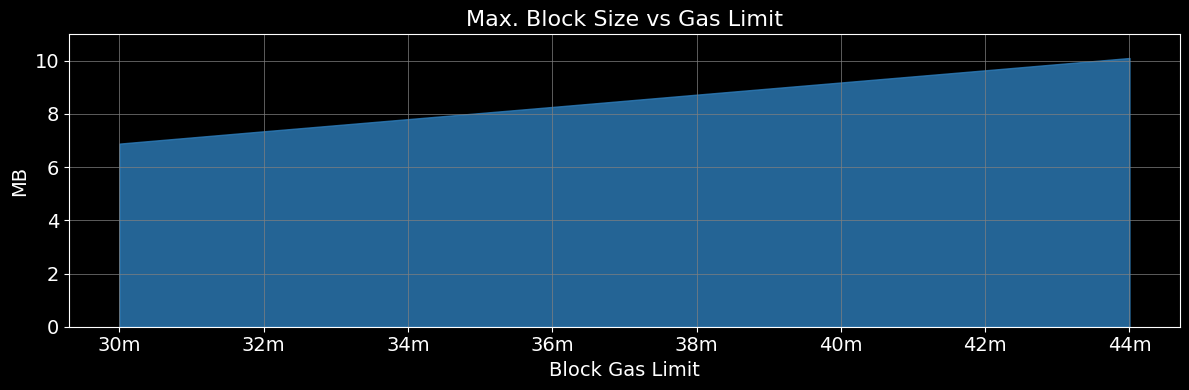

In [15]:
def format_func(value, tick_number):
    return f'{int(value / 1_000_000)}m'
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 4))
x = gas_limits_empty
y = block_sizes_empty
colors = cm.Blues(0.7)
plt.rcParams['font.family'] = 'Ubuntu Mono'
ax.fill_between(x, y, color=colors, alpha=0.8)
ax.set_xlabel('Block Gas Limit', fontsize=14)
ax.set_ylabel('MB', fontsize=14)
ax.set_title('Max. Block Size vs Gas Limit', fontsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
ax.set_ylim(0, 10.99)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.legend_ = None
plt.savefig("impact_block_gas_limit.png")
plt.show()

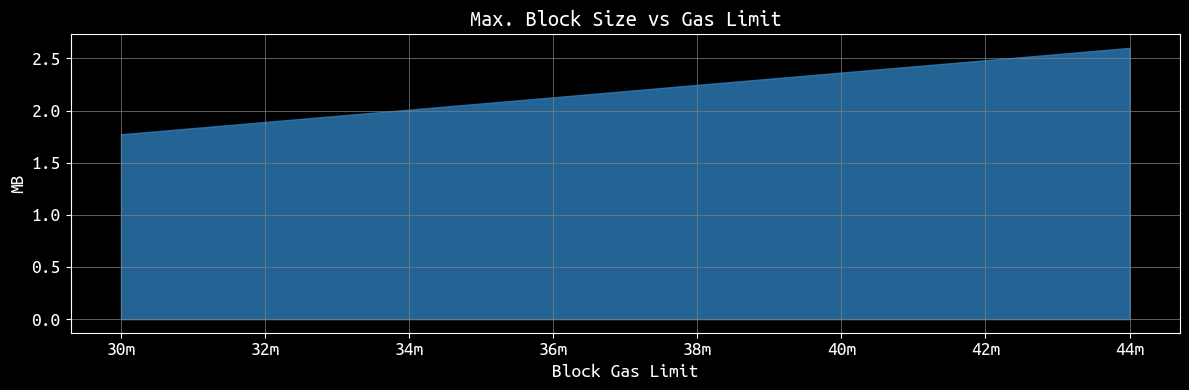

In [16]:
def format_func(value, tick_number):
    return f'{int(value / 1_000_000)}m'
plt.style.use('dark_background')
x = gas_limits
y = block_sizes
colors = cm.Blues(0.7)
fig, ax = plt.subplots(figsize=(12, 4))
plt.rcParams['font.family'] = 'Ubuntu Mono'
ax.fill_between(x, y, color=colors, alpha=0.8)
ax.set_xlabel('Block Gas Limit', fontsize=14)
ax.set_ylabel('MB', fontsize=14)
ax.set_title('Max. Block Size vs Gas Limit', fontsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.legend_ = None
plt.savefig("impact_block_gas_limit.png")
plt.show()

In [17]:
def get_max_block_size_in_mb(gas_cost, emptybytes=True):
    
    gas_for_calldata = max_calldata_size * gas_cost  
    total_gas_per_transaction = transaction_base_cost + gas_for_calldata
    transactions_per_block = block_gas_limit//total_gas_per_transaction
    print(f"{transactions_per_block} transactions fit in one block")
    block_size = transactions_per_block * max_transaction_size
    
    remaining_gas = block_gas_limit%total_gas_per_transaction
    remaining_space_for_calldata = (remaining_gas - transaction_base_cost) / gas_cost

    block_size += 1 * remaining_space_for_calldata
    print(f"Block size: {block_size/1024**2} MB")
    return block_size/1024**2

calldata_costs = [4, 8, 16, 24, 32, 40, 64, 128]
block_sizes = [get_max_block_size_in_mb(i, emptybytes=False) for i in calldata_costs]

55 transactions fit in one block
Block size: 6.882719993591309 MB
28 transactions fit in one block
Block size: 3.509047508239746 MB
14 transactions fit in one block
Block size: 1.772047519683838 MB
9 transactions fit in one block
Block size: 1.1854734420776367 MB
7 transactions fit in one block
Block size: 0.8904047012329102 MB
5 transactions fit in one block
Block size: 0.7132101058959961 MB
3 transactions fit in one block
Block size: 0.44635820388793945 MB
1 transactions fit in one block
Block size: 0.2233961820602417 MB


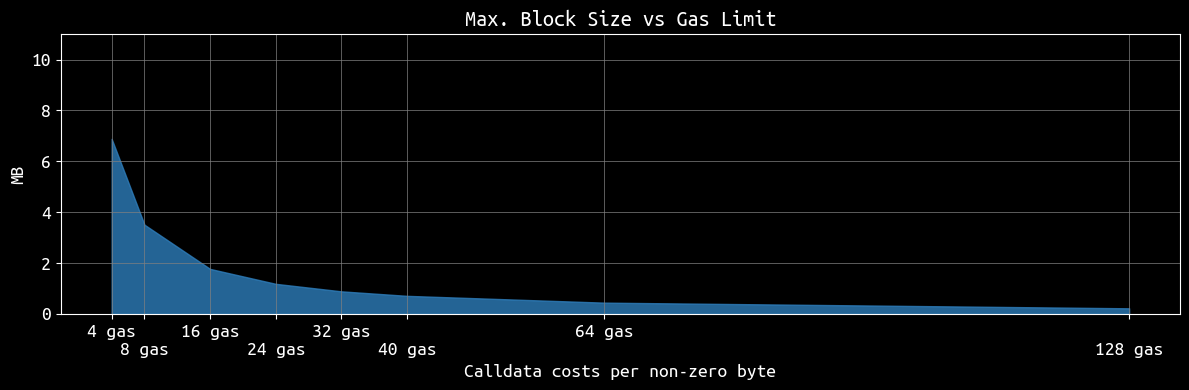

In [18]:
plt.style.use('dark_background')
x = calldata_costs
y = block_sizes
colors = cm.Blues(0.7)
fig, ax = plt.subplots(figsize=(12, 4))
plt.rcParams['font.family'] = 'Ubuntu Mono'
ax.fill_between(x, y, color=colors, alpha=0.8)
ax.set_xlabel('Calldata costs per non-zero byte', fontsize=14)
ax.set_xticks(calldata_costs)
ax.set_xticklabels([str(j) + " gas" if i % 2 == 0 else "\n" + str(j) + " gas" for i, j in enumerate(calldata_costs)]
                  , fontsize=14)
ax.set_ylabel('MB', fontsize=14)
ax.set_title('Max. Block Size vs Gas Limit', fontsize=16)
ax.set_ylim(0, 10.99)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.legend_ = None
plt.savefig("impact_calldata_price.png")
plt.show()